<a href="https://colab.research.google.com/github/tomeravgil/Homework2CSCI6170/blob/main/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Selected

Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

In [ ]:
!pip install ucimlrepo
!pip install pandas
!pip install numpy

## Task 1

In [ ]:
import numpy as np
import pandas as pd

class NeuralNetwork:

  def __init__(self, layer_sizes):
        self.L = len(layer_sizes) - 1
        self.weights = []
        self.biases = []

        for l in range(1, len(layer_sizes)):
            self.weights.append(
                np.random.randn(layer_sizes[l], layer_sizes[l-1]) *
                np.sqrt(2 / layer_sizes[l-1])
            )
            self.biases.append(np.zeros((layer_sizes[l], 1)))

  def forward_prop(self, X):
      A = X
      for l in range(self.L - 1):
          A = self._relu(self.weights[l] @ A + self.biases[l])

      # output layer
      A = self._sigmoid(self.weights[self.L-1] @ A +
                        self.biases[self.L-1])
      return A

  def cached_forward_prop(self, X):
      A = X
      Z_cache = []
      A_cache = [X]  # include input

      for l in range(self.L - 1):
          Z = self.weights[l] @ A + self.biases[l]
          A = self._relu(Z)
          Z_cache.append(Z)
          A_cache.append(A)

      Z = self.weights[self.L-1] @ A + self.biases[self.L-1]
      A = self._sigmoid(Z)
      Z_cache.append(Z)
      A_cache.append(A)

      return A, Z_cache, A_cache

  def backward_prop(self, y_hat, y, A, Z):
      L = self.L

      dW = [None] * L
      dB = [None] * L

      dZ = y_hat - y

      dW[L-1] = dZ @ A[L-1].T
      dB[L-1] = np.sum(dZ, axis=1, keepdims=True)

      for l in range(L-2, -1, -1):
          dZ = (self.weights[l+1].T @ dZ) * (Z[l] > 0)
          dW[l] = dZ @ A[l].T
          dB[l] = np.sum(dZ, axis=1, keepdims=True)

      return dW, dB

  def train(self, X, Y, epochs, lr):

      n_samples = X.shape[1]

      for epoch in range(epochs):
        y_hat, Z, A = self.cached_forward_prop(X)

        dW, dB = self.backward_prop(y_hat, Y, A, Z)

        for l in range(self.L):
            self.weights[l] -= lr * dW[l] / X.shape[1]
            self.biases[l] -= lr * dB[l] / X.shape[1]


  def calculate_cost(self, X, Y):
      n_samples = X.shape[1]
      total = 0
      for i in range(n_samples):
          y_hat = self.forward_prop(X[:, i:i+1])
          total += self._loss(Y[:, i:i+1], y_hat)
      return total / n_samples

  def predict(self, X):
      return self.forward_prop(X)

  def _relu(self, x):
      return np.maximum(0, x)

  def _sigmoid(self, x):
      return 1 / (1 + np.exp(-x))

  def _loss(self, y, y_hat):
      return -y*np.log(y_hat) - (1-y)*np.log(1-y_hat)

In [ ]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets


y = (y.values.flatten() == '>50K').astype(int)


X = pd.get_dummies(X, drop_first=True)


X = X.values.astype(float)


scaler = StandardScaler()
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


X_train = X_train.T
X_test = X_test.T
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)


input_size = X_train.shape[0]

nn = NeuralNetwork([
    input_size,
    28,
    28,
    1
])


nn.train(X_train, y_train, epochs=50, lr=0.01)


y_pred = nn.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = np.mean(y_pred_binary == y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8165625959668339


## Part 2

## Task 1

For the framework I chose, I decided to go forward with PyTorch due to its heavy usage in research and popularity.

For my resources, I will be following the build the neural network tutorial

https://docs.pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

As well, I will be learning how gradients are computed automatically to have the correct context when needed for debugging

https://docs.pytorch.org/docs/stable/autograd.html

In terms of functions:

- torch.nn.Linear
- torch.nn.ReLU
- torch.nn.Sigmoid
- loss_function = torch.nn.BCELoss()
- optimizer = torch.nn.BCELoss()
- loss.backward()
- optimizer.step()

## Task 2

Class distribution before balancing:
income
0    37688
1     7506
Name: count, dtype: int64
Class distribution after balancing:
income
0    37688
1    37688
Name: count, dtype: int64


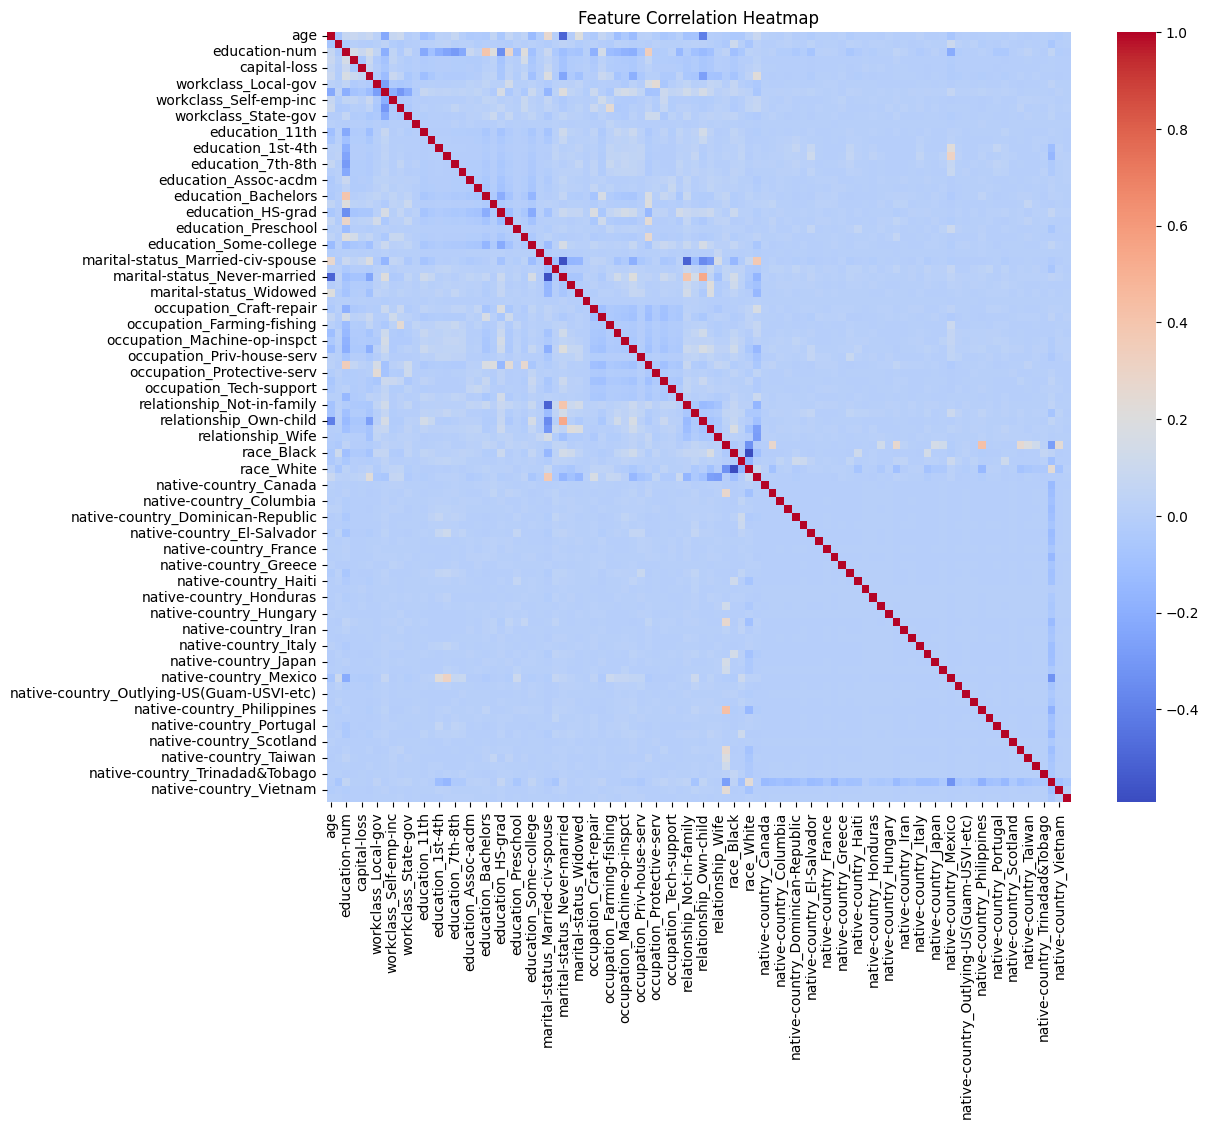

In [ ]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

adult = fetch_ucirepo(id=2)

X = adult.data.features.copy()
y = adult.data.targets.copy()


# duplicate removal

data = pd.concat([X, y], axis=1)
data = data.drop_duplicates()

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# missing values

X = X.replace('?', np.nan)
X = X.dropna()
y = y.loc[X.index]


y = (y == '>50K').astype(int)

X = pd.get_dummies(X, drop_first=True)

print("Class distribution before balancing:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)

print("Class distribution after balancing:")
print(pd.Series(y_bal).value_counts())

plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(X_bal).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_bal, y_bal, test_size=0.3, random_state=42
)

X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

from sklearn.preprocessing import StandardScaler

X_train_np = X_train
X_dev_np = X_dev
X_test_np = X_test

y_train_np = y_train.values
y_dev_np = y_dev.values
y_test_np = y_test.values


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_dev = torch.tensor(X_dev, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
y_dev = torch.tensor(y_dev.values, dtype=torch.float32).view(-1,1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

In [ ]:
class AdultNN(nn.Module):

    def __init__(self, input_size):
        super(AdultNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 28),
            nn.ReLU(),
            nn.Linear(28, 28),
            nn.ReLU(),
            nn.Linear(28, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
model = AdultNN(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):

    model.train()

    for batch_X, batch_y in train_loader:

        optimizer.zero_grad()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

model.eval()

with torch.no_grad():
    test_outputs = model(X_test)
    predictions = (test_outputs > 0.5).float()
    accuracy = (predictions == y_test).float().mean()

print("Test Accuracy:", accuracy.item())


Epoch 0, Loss: 0.2610
Epoch 10, Loss: 0.0351
Epoch 20, Loss: 0.1902
Epoch 30, Loss: 0.0982
Epoch 40, Loss: 0.2752
Test Accuracy: 0.8985584378242493


## Task 3

The main hyper parameters that were chosen were:

- 2 hidden layers with 28 neurons each
- ReLU for the hidden layers and sigmoid for the output layers
- Learning Rate of 0.001
- batch size of 64
- 50 epochs
- Adam optimizer

28 neurons per layer were chosen as it is double the feature size and was considered large enough to model nonlinear relationships given the data, but small enough to avoid overfitting.

ReLu was used for hidden layers to avoid the vanishing gradient and is considered standard practice for deep neural networks

Sigmoid was used due to the problem being a binary classification problem since Sigmoid can produce probabilities in the range of 0 to 1 and aligns with Binary Cross Entropy Loss.

The learning rate was chosen since it is a default and stable value for Adam.

Adam was used since it adapts the learning rate per parameter, converges faster in practice, and is robust to noisy gradients.

Regularization was used via balancing of data sets and early stopping.


## Task 4

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_np, y_train_np)

y_pred = xgb_model.predict(X_test_np)
y_prob = xgb_model.predict_proba(X_test_np)[:, 1]

print("XGBoost Accuracy:", accuracy_score(y_test_np, y_pred))
print("XGBoost ROC-AUC:", roc_auc_score(y_test_np, y_prob))


XGBoost Accuracy: 0.9028920137967631
XGBoost ROC-AUC: 0.9708839614134358


XGBoost outperformed the neural network due to its ability to capture non linear interactions and is effective with tabular data. Boosted trees model feature interactions without the need for feature scaling or deep architectures. Neural netowkrs are more useful for unstructured data such as images or text.